In [1]:
# setting device on GPU if available, else CPU
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 2080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn

from torch.utils.data import DataLoader

from torch.utils import data


import copy
import os
import random
import cv2
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import functools
from tqdm import tqdm
from datetime import datetime
import numpy as np
from functools import partial
# from core.datasets.vqa_motion_dataset import VQMotionDataset,DATALoader,VQVarLenMotionDataset,MotionCollator
from einops import rearrange, reduce, pack, unpack
import sys

In [4]:
def findAllFile(base):
    """
    Recursively find all files in the specified directory.

    Args:
        base (str): The base directory to start the search.

    Returns:
        list: A list of file paths found in the directory and its subdirectories.
    """
    file_path = []
    for root, ds, fs in os.walk(base, followlinks=True):
        for f in fs:
            fullname = os.path.join(root, f)
            file_path.append(fullname)
    return file_path

In [5]:
pwd

'/coc/scratch/sanisetty3/music_motion/ATCMG'

In [5]:
# from configs.config_t2m import cfg, get_cfg_defaults
# from yacs.config import CfgNode as CN


In [6]:
# body_cfg = get_cfg_defaults()
# body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse_body_hands.yaml")

In [7]:
# pkg = torch.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/motion_muse_body_hands/motion_muse.pt")

In [8]:
# pkg["config"] = dict(body_cfg)

In [9]:
from utils.motion_processing.hml_process import recover_from_ric, recover_root_rot_pos
import utils.vis_utils.plot_3d_global as plot_3d
import matplotlib.pyplot as plt

## VQVAE

In [6]:
from core.datasets.vq_dataset import VQSMPLXMotionDataset
from core.datasets.vq_dataset import load_dataset, simple_collate
from configs.config import cfg, get_cfg_defaults
from core.datasets.conditioner import ConditionProvider
from core import MotionRep
from core.models.utils import instantiate_from_config, get_obj_from_str
from core.models.loss import ReConsLoss
from core.models.resnetVQ.rq_vqvae import HumanRVQVAE

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def get_decoded(model , motion):
    encs = []
    inds = []
    for i in range(0 , motion.shape[1] , 120 ):
        if i + 240 >= motion.shape[1]:
            enc_b = model(motion[: , i:, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
            break
        else:
            enc_b = model(motion[: , i:i + 120, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
    return torch.cat(encs , 1), torch.cat(inds , -1)

In [7]:
def motion_dim(hml_rep, motion_rep, joints = 52, remove_trans=False):
    dim = 0

    if "g" in hml_rep:
        if remove_trans:
            dim += 2
        else:
            dim += 4
    if "p" in hml_rep:
        if motion_rep == MotionRep.BODY or motion_rep == MotionRep.FULL:
            dim += (joints - 1) * 3
        else:
            dim += (joints) * 3
    if "r" in hml_rep:
        if motion_rep == MotionRep.BODY or motion_rep == MotionRep.FULL:
            dim += (joints - 1) * 6
        else:
            dim += (joints) * 6
    if "v" in hml_rep:
        dim += joints * 3
    if "c" in hml_rep:
        dim += 4

    return dim

In [8]:
motion_dim("gpvc" , MotionRep.FULL , 52)

317

In [10]:
body_cfg = get_cfg_defaults()
body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gpvc_1024/vqvae_body_gpvc_1024.yaml")
dataset_args = body_cfg.dataset
model_args = body_cfg.vqvae

In [11]:
body_model = instantiate_from_config(body_cfg.vqvae).to(device)
body_model.load(os.path.join(body_cfg.output_dir, "vqvae_motion.pt"))

Sync is turned on False
loaded model with  0.036310043185949326 tensor([100000.], device='cuda:0') steps


In [25]:
from core.models.loss import ReConsLoss

loss_fnc = ReConsLoss(
            recons_loss=model_args.recons_loss,
            use_geodesic_loss=model_args.use_geodesic_loss,
            nb_joints=model_args.nb_joints,
            hml_rep=dataset_args.hml_rep,
            motion_rep=MotionRep(dataset_args.motion_rep),
            use_simple_loss = False,
            # remove_translation=True
        )

In [19]:
# full_model = HumanRVQVAE(body_cfg.vqvae).to(device)

In [14]:
dataset_names_default = [
    "animation",
    "humanml",
    "perform",
    "GRAB",
    "idea400",
    "humman",
    "beat",
    "game_motion",
    "music",
    "aist",
    "fitness",
    "moyo",
    "choreomaster",
    "dance",
    "kungfu",
    "EgoBody",
    # "HAA500",
]

In [11]:
dataset_args.window_size = -1

In [15]:
train_ds, sampler_train, weights_train = load_dataset(
            dataset_names=dataset_names_default,
            dataset_args=body_cfg.dataset,
            split="test",
        )

Total number of motions animation: 2
Total number of motions humanml: 2944
Total number of motions perform: 16
Total number of motions GRAB: 67
Total number of motions idea400: 577
Total number of motions humman: 19
Total number of motions beat: 162
Total number of motions game_motion: 130
Total number of motions music: 148
Total number of motions aist: 61
Total number of motions fitness: 572
Total number of motions moyo: 9
Total number of motions choreomaster: 2
Total number of motions dance: 7
Total number of motions kungfu: 42
Total number of motions EgoBody: 49


In [16]:

condition_provider = ConditionProvider(
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            only_motion=True
        )
train_loader = torch.utils.data.DataLoader(
        train_ds,
        200,
        # sampler=sampler_train,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
    )

In [21]:
@torch.no_grad()
def compute_perplexity(code_idx):
    # Calculate new centres
    code_onehot = torch.zeros(
        model_args.codebook_size, code_idx.shape[0], device=code_idx.device
    )  # nb_code, N * L
    code_onehot.scatter_(0, code_idx.view(1, code_idx.shape[0]), 1)

    code_count = code_onehot.sum(dim=-1)  # nb_code
    prob = code_count / torch.sum(code_count)
    perplexity = torch.exp(-torch.sum(prob * torch.log(prob + 1e-7)))
    return perplexity
def validation_step():
    val_loss_ae = {}
    
    cnt = 0
    
    with torch.no_grad():
        for batch in tqdm(train_loader):
            gt_motion = batch["motion"][0].to(device)
            
            vqvae_output = body_model(
                motion=gt_motion,
                # mask=mask,
            )
    
            loss_motion = loss_fnc(
                vqvae_output.decoded_motion, gt_motion, mask=None
            )
    
            loss = model_args.loss_motion * loss_motion+ model_args.commit * vqvae_output.commit_loss
            perplexity = compute_perplexity(vqvae_output.indices.flatten())
    
            loss_dict = {
                "total_loss": loss.detach().cpu(),
                "loss_motion": loss_motion.detach().cpu(),
                "commit_loss": vqvae_output.commit_loss.detach().cpu(),
                "perplexity": perplexity,
            }
    
            for key, value in loss_dict.items():
                if key in val_loss_ae:
                    val_loss_ae[key] += value
                else:
                    val_loss_ae[key] = value
    
            cnt += 1
    
    for key in val_loss_ae.keys():
        val_loss_ae[key] = val_loss_ae[key] / cnt
        print(key , val_loss_ae[key])

In [27]:
body_model = instantiate_from_config(body_cfg.vqvae).to(device)
body_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gpvc_1024/checkpoints/vqvae_motion.100000.pt")

Sync is turned on False
loaded model with  0.036310043185949326 tensor([100000.], device='cuda:0') steps


In [28]:
validation_step()

100%|██████████████████████████████████████████████████████████████████| 25/25 [00:08<00:00,  2.92it/s]

total_loss tensor(0.3089)
loss_motion tensor(0.1443)
commit_loss tensor(0.0815)
perplexity tensor(476.7220, device='cuda:0')


In [ ]:
total_loss tensor(0.3134)
loss_motion tensor(0.1180)
commit_loss tensor(0.3095)
perplexity tensor(456.9408, device='cuda:0')

In [23]:
def remtrans(mot):
    l = list(range(0, mot.shape[-1]))
    ohprvc = l[:1] + l[3:]
    mot = mot[..., ohprvc]
    return mot

def addtrans(mot):
    z = torch.zeros(
        mot.shape[:-1] + (2,),
        dtype=mot.dtype,
        device=mot.device,
    )

    mot = torch.cat(
        [mot[..., 0:1], z, mot[..., 1:]], -1
    )
    return mot

In [15]:
for batch in train_loader:
    break
batch["names"]

array(['idea400/subset_0049/Put_On_The_Jacket_And_Standing_At_The_Same_Time_clip_1.npy',
       'idea400/subset_0015/Selfie_And_Walking_At_The_Same_Time.npy',
       'idea400/subset_0020/Walking_While_Spread_Your_Hands.npy',
       'idea400/subset_0040/Riding_The_Ferris_Wheel_During_Sitting.npy'],
      dtype='<U78')

In [16]:
batch["names"]

array(['idea400/subset_0049/Put_On_The_Jacket_And_Standing_At_The_Same_Time_clip_1.npy',
       'idea400/subset_0015/Selfie_And_Walking_At_The_Same_Time.npy',
       'idea400/subset_0020/Walking_While_Spread_Your_Hands.npy',
       'idea400/subset_0040/Riding_The_Ferris_Wheel_During_Sitting.npy'],
      dtype='<U78')

In [17]:
gt_motion = batch["motion"][0].to(device)

In [18]:
out = body_model(gt_motion) 

In [19]:
motion_pred = out.decoded_motion

In [20]:
loss = loss_fnc(motion_pred , gt_motion)

In [256]:
params_pred = torch.split(motion_pred, [4, 153, 156, 4], -1)
params_gt = torch.split(gt_motion, [4, 153, 156, 4], -1)
fid_r, fid_l = [8, 11], [7, 10]
vel_param = params_gt[-2]
vel = vel_param.contiguous().view(vel_param.shape[:2] + (52, 3))
pred_c = loss_fnc.get_c_from_v(params_pred[-2])

In [200]:
vl = vel[:, :, fid_l]
vr = vel[:, :, fid_r]


In [190]:
gt_c = 2*gt_motion[...,-4:] - 1
prm_pred_c = 2*params_pred[-1][...,-4:] - 1

In [191]:
_binary_hinge_loss(pred_c , gt_c ).mean()

tensor(1.9972, device='cuda:0', grad_fn=<MeanBackward0>)

In [157]:
nn.functional.hinge_embedding_loss(pred_c , gt_c)

tensor(293.7635, device='cuda:0', grad_fn=<MeanBackward0>)

In [171]:
1 - ((pred_c).reshape(-1) * gt_c.reshape(-1)).mean()

tensor(0.9995, device='cuda:0', grad_fn=<RsubBackward1>)

In [194]:
1 - ((pred_c).reshape(-1) * prm_pred_c.reshape(-1)).mean()

tensor(1.0014, device='cuda:0', grad_fn=<RsubBackward1>)

In [144]:
losses = 1 - (torch.mul(pred_c, gt_c))
torch.norm(nn.functional.relu(losses))

tensor(30.9476, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [149]:
losses = 1 - (torch.mul(pred_c, gt_c))
torch.norm(nn.functional.relu(losses))

tensor(28.9765, device='cuda:0', grad_fn=<LinalgVectorNormBackward0>)

In [202]:
fid_r, fid_l = [8, 11], [7, 10]
params_gt = torch.split(gt_motion, [2, 63, 66, 4], -1)

In [172]:
pos = params_gt[1].reshape((4,120,21,3))
vel = params_gt[2].reshape((4,120,22,3))

In [142]:
pos[:,:,[1, 4, 7, 10, 0, 3, 6, 9]] =0 
# vel[:,:,[2, 5, 8, 11, 1, 4, 7, 10]] =0 

In [114]:
pred_c = loss_fnc.get_c_from_v(vel)

NameError: name 'vel' is not defined

In [143]:
new_mot = torch.cat([params_gt[0] , pos.reshape(4,120,-1) , vel.reshape(4,120,-1), params_gt[-1] ] , -1)

In [104]:
new_mot.shape

torch.Size([4, 120, 135])

In [203]:
vqvae_output = body_model(gt_motion)
pred_motion = vqvae_output.decoded_motion
params_pred = torch.split(pred_motion, [2, 63, 66, 4], -1)

In [190]:
gt_motion.shape

torch.Size([4, 120, 135])

In [211]:
loss_fnc(gt_motion , pred_motion)

tensor(2.7267, device='cuda:0', grad_fn=<AddBackward0>)

In [152]:
pred_c_pred = loss_fnc.get_c_from_v(params_pred[2].reshape((4,120,22,3)))

In [156]:
nn.functional.binary_cross_entropy_with_logits(pred_c_pred , pred_c )

tensor(-123.6793, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [145]:
pred_motion = addtrans(pred_motion)

In [146]:
gt_motion = addtrans(gt_motion)

In [109]:
train_ds.datasets[0].render_hml(
                    pred_motion[1].detach().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/render_test.gif", zero_trans=True , zero_orient=True )

## Loss stuff

In [183]:
loss_fnc(gt_motion , pred_motion)

RuntimeError: split_with_sizes expects split_sizes to sum exactly to 135 (input tensor's size at dimension -1), but got split_sizes=[4, 63, 66, 4]

In [26]:
params_gt = torch.split(gt_motion, [4, 153, 156, 4], -1)

In [72]:
params_pred = torch.split(pred_motion, [4, 153, 156, 4], -1)

In [37]:
params_gt[-1][2][:,:2]

tensor([[1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1., 1.],
        [1

torch.Size([4, 120, 52, 3])

In [93]:
fid_r, fid_l = [8, 11], [7, 10]
vel = params_gt[-2].contiguous().view(params_gt[-2].shape[:2] + (52 , 3))
pred_cl = (torch.sum(vel[: , : , fid_l]**2 , dim = -1)  - 0.002)
pred_cr = (torch.sum(vel[: , : , fid_r]**2 , dim = -1)   - 0.002 )
pred_c = torch.cat([pred_cl , pred_cr] , -1) 

In [94]:
vel2 = params_pred[-2].contiguous().view(params_pred[-2].shape[:2] + (52 , 3))
pred_cl2 = (torch.sum(vel2[: , : , fid_l]**2 , dim = -1)  - 0.002)
pred_cr2 = (torch.sum(vel2[: , : , fid_r]**2 , dim = -1)   - 0.002 )
pred_c2 = torch.cat([pred_cl2 , pred_cr2] , -1) 

In [90]:
pred_c.shape

torch.Size([4, 120, 4])

In [92]:
nn.functional.sigmoid(1e3*pred_c)[2]

tensor([[0.1362, 0.1337, 0.1417, 0.1486],
        [0.1257, 0.1235, 0.1333, 0.1287],
        [0.1212, 0.1203, 0.1368, 0.1244],
        [0.1205, 0.1205, 0.2200, 0.1857],
        [0.1227, 0.1211, 0.5022, 0.4564],
        [0.1243, 0.1220, 0.7181, 0.7111],
        [0.1297, 0.1231, 0.8875, 0.9029],
        [0.1262, 0.1220, 0.9042, 0.9424],
        [0.1218, 0.1212, 0.9466, 0.9769],
        [0.1228, 0.1199, 0.9726, 0.9917],
        [0.1261, 0.1198, 0.9896, 0.9977],
        [0.1254, 0.1202, 0.9889, 0.9973],
        [0.1250, 0.1213, 0.9884, 0.9969],
        [0.1224, 0.1206, 0.9422, 0.9743],
        [0.1200, 0.1202, 0.7925, 0.8594],
        [0.1210, 0.1205, 0.6797, 0.7429],
        [0.1223, 0.1214, 0.5596, 0.6007],
        [0.1225, 0.1295, 0.2403, 0.2365],
        [0.1314, 0.1492, 0.1412, 0.1275],
        [0.1254, 0.1372, 0.1253, 0.1219],
        [0.1217, 0.1282, 0.1207, 0.1242],
        [0.1323, 0.1215, 0.1313, 0.1201],
        [0.1897, 0.1448, 0.1773, 0.1306],
        [0.1626, 0.1378, 0.1313, 0

In [81]:
params_gt[-1][2]

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 0., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1.,

In [96]:
nn.functional.sigmoid(1e3*pred_c2)[2]

tensor([[0.1678, 0.1771, 0.2791, 0.1244],
        [0.1665, 0.1632, 0.3834, 0.1200],
        [0.1500, 0.1980, 0.3479, 0.1198],
        [0.1480, 0.2139, 0.3985, 0.1206],
        [0.1514, 0.2388, 0.4308, 0.1201],
        [0.1593, 0.2427, 0.4499, 0.1199],
        [0.1589, 0.2473, 0.4625, 0.1198],
        [0.1608, 0.2481, 0.4487, 0.1198],
        [0.1615, 0.2526, 0.4556, 0.1199],
        [0.1597, 0.2612, 0.4654, 0.1203],
        [0.1584, 0.2675, 0.4587, 0.1205],
        [0.1579, 0.2590, 0.4684, 0.1199],
        [0.1597, 0.2693, 0.4740, 0.1201],
        [0.1605, 0.2606, 0.4666, 0.1197],
        [0.1612, 0.2565, 0.4705, 0.1195],
        [0.1591, 0.2685, 0.4773, 0.1207],
        [0.1561, 0.2635, 0.4763, 0.1206],
        [0.1530, 0.2780, 0.4933, 0.1202],
        [0.1549, 0.2664, 0.5009, 0.1204],
        [0.1530, 0.2598, 0.4861, 0.1202],
        [0.1552, 0.2629, 0.4779, 0.1203],
        [0.1529, 0.2580, 0.4669, 0.1199],
        [0.1516, 0.2604, 0.4516, 0.1198],
        [0.1506, 0.2609, 0.4679, 0

In [95]:
nn.functional.binary_cross_entropy_with_logits(1e3*pred_c2 , params_gt[-1] )

tensor(1.4711, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [59]:
# !python train_vqvae.py

## Get indices

In [5]:
from core.datasets.vq_dataset import VQSMPLXMotionDataset
from core.datasets.vq_dataset import load_dataset, simple_collate
from configs.config import cfg, get_cfg_defaults
from core.datasets.conditioner import ConditionProvider
from core import MotionRep
from core.models.utils import instantiate_from_config, get_obj_from_str
from core.models.loss import ReConsLoss
from core.models.resnetVQ.rq_vqvae import HumanRVQVAE

/srv/hays-lab/flash5/sanisetty3/miniconda3/envs/tgm3d/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def get_decoded(model , motion):
    encs = []
    inds = []
    seq = motion.shape[1]
    motion = motion[: , :(seq//4)*4] 
    for i in range(0 , motion.shape[1] , 120 ):
        if i + 240 >= motion.shape[1]:
            enc_b = model(motion[: , i:, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
            break
        else:
            enc_b = model(motion[: , i:i + 120, :].to(device))
            encs.append(enc_b.decoded_motion)
            inds.append(enc_b.indices)
    return torch.cat(encs , 1), torch.cat(inds , -1)

In [7]:
body_cfg = get_cfg_defaults()
body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_body_gprvc.yaml")

dataset_args = body_cfg.dataset
model_args = body_cfg.vqvae

In [8]:
body_cfg.output_dir

'/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc'

In [9]:
body_model = instantiate_from_config(body_cfg.vqvae).to(device).eval()
body_model.load("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/vqvae/vqvae_body_gprvc/vqvae_motion.pt")
body_model.freeze()

Sync is turned on False
loaded model with  1.1994400024414062 tensor([110000.], device='cuda:0') steps


In [10]:
dataset_args.window_size = -1

In [20]:
train_ds, sampler_train, weights_train = load_dataset(
            # dataset_names=["moyo"],
            dataset_args=dataset_args,
            split="test",
        )

Total number of motions animation: 17
Total number of motions humanml: 3546
Total number of motions perform: 24
Total number of motions GRAB: 67
Total number of motions idea400: 626
Total number of motions humman: 38
Total number of motions beat: 162
Total number of motions game_motion: 511
Total number of motions music: 179
Total number of motions aist: 74
Total number of motions fitness: 837
Total number of motions moyo: 9
Total number of motions choreomaster: 2
Total number of motions dance: 9
Total number of motions kungfu: 52
Total number of motions EgoBody: 49
Total number of motions HAA500: 262


In [22]:

condition_provider = ConditionProvider(
            motion_rep=MotionRep(dataset_args.motion_rep),
            only_motion=True
        )
dl = torch.utils.data.DataLoader(
        train_ds,
        1,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
    )

In [23]:
# for batch in dl:
#     break
# batch["names"]

In [19]:
batch["motion"][0].shape

torch.Size([1, 116, 263])

In [79]:
out = body_model(batch["motion"][0] , temperature = 0)

In [17]:
enc , ind = get_decoded(body_model , batch["motion"][0])

In [16]:
indl = np.load("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body_gprvc/moyo/220923_yogi_body_hands_03596_Boat_Pose_or_Paripurna_Navasana_-a_stageii.npy")

In [19]:
# body_model.decode(torch.LongTensor(indl).to(device))

In [18]:
train_ds.datasets[0].render_hml(
                    body_model.decode(torch.LongTensor(indl).to(device)).squeeze().cpu(),
                    "/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/render/gen_full_gprvc.gif",
    # zero_orient = True,
    # zero_trans=  True,
                )

In [24]:
errors = []
for input in tqdm(dl):
    sve = os.path.join("/srv/hays-lab/scratch/sanisetty3/motionx/indices/body_gprvc" , input["names"][0] )
    if os.path.exists(sve):
        continue
    os.makedirs(os.path.dirname(sve) , exist_ok=True)
    try:
        # if "g" in body_cfg.dataset.hml_rep:
        #     l = list(range(0, batch["motion"][0].shape[-1]))
        #     ohprvc = l[:1] + l[3:]
        #     gt_motion = batch["motion"][0][..., ohprvc]
        enc_b, inb = get_decoded(body_model ,  input["motion"][0].to(device))
        np.save(sve , inb.cpu().numpy())
    except:
        errors.append(input["names"][0])
    

100%|███████████████████████████████████████████████████████████████| 6464/6464 [08:42<00:00, 12.36it/s]


In [29]:
len(errors)

0

## Translation

In [133]:
from core.datasets.translation_dataset import load_dataset,simple_collate
from configs.config import cfg, get_cfg_defaults
from core.datasets.conditioner import ConditionProvider
from core import MotionRep
from core.models.utils import instantiate_from_config, get_obj_from_str
import utils.rotation_conversions as geometry


In [134]:
from configs.config_t2o import cfg, get_cfg_defaults

In [135]:
body_cfg = get_cfg_defaults()
body_cfg.merge_from_file("/srv/hays-lab/scratch/sanisetty3/music_motion/ATCMG/checkpoints/simple_motion_translation/simple_motion_translation.yaml")

In [136]:
dataset_args = body_cfg.dataset
model_args = body_cfg.vqvae

In [137]:
trans_model = instantiate_from_config(model_args).to(device).eval()
trans_model.load(os.path.join(body_cfg.output_dir, "tcn_model.pt"))

Sync is turned on False
loaded model with  0.06821402907371521 tensor([40000.], device='cuda:0') steps


In [132]:
train_ds, sampler_train, weights_train = load_dataset(
            dataset_names=["choreomaster" , "idea400"],
            dataset_args=body_cfg.dataset,
            split="train",
        )

Total number of motions choreomaster: 34
Total number of motions idea400: 10946


In [121]:

condition_provider = ConditionProvider(
            motion_rep=MotionRep(body_cfg.dataset.motion_rep),
            only_motion=True
        )
train_loader = torch.utils.data.DataLoader(
        train_ds,
        4,
        sampler=sampler_train,
        collate_fn=partial(simple_collate , conditioner = condition_provider),
    )

In [22]:
def cossin2quat(r_rot):
    mat = torch.zeros(
        (
            r_rot.shape[:-1]
            + (
                3,
                3,
            )
        )
    ).to(r_rot.device)
    mat[..., 1, 1] = 1
    mat[..., 0, 0] = r_rot[..., 0]
    mat[..., 0, 2] = r_rot[..., 1]
    mat[..., 2, 0] = -r_rot[..., 1]
    mat[..., 2, 2] = r_rot[..., 0]
    r_rot_quat = geometry.matrix_to_quaternion(mat)
    return r_rot_quat

In [23]:
for batch in train_loader:
    break


In [24]:
batch["names"]

array(['choreomaster/1138.npy', 'choreomaster/1072.npy',
       'idea400/subset_0044/Simultaneously_Sitting_And_Both_Wrists_Touch.npy',
       'idea400/subset_0020/Simultaneously_Standing_And_Spread_Your_Hands.npy'],
      dtype='<U69')

In [122]:
gt_motion = batch["motion"][0].to(device)


In [123]:
gt_motion.shape

torch.Size([4, 120, 7])

In [124]:
rel_pos = gt_motion[..., 4:][..., [0, 2]]

In [125]:
r_rot = gt_motion[..., :4]
r_rot2 = geometry.quaternion_to_matrix(r_rot)[..., [0, 0], [0, 2]]

In [126]:
r_rot_rec = cossin2quat(r_rot2)

In [45]:
from scipy.ndimage import gaussian_filter1d


In [142]:
with torch.no_grad():
    out = trans_model(gt_motion)
    pred_traj = out.decoded_motion[...,:2].cpu().numpy()
    pred_orient = out.decoded_motion[...,2:].cpu().clamp(min = -1, max = 1).numpy()
    pred_orient[:,0,0] = 1
    pred_orient[:,0,1] = 0

In [138]:
with torch.no_grad():
    pred_quat = trans_model.predict(rel_pos).cpu().numpy()

In [88]:
pred_orient[...,:] = gaussian_filter1d(pred_orient[...,:], 10, axis=-1, mode="nearest")

In [139]:
pred_quat[0]

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 9.33320701e-01,  0.00000000e+00, -3.59043777e-01,
         0.00000000e+00],
       [ 8.56353641e-01,  0.00000000e+00, -5.16389787e-01,
         0.00000000e+00],
       [ 7.86286116e-01,  6.10351562e-05, -6.17862582e-01,
         0.00000000e+00],
       [ 6.92203879e-01,  0.00000000e+00, -7.21701980e-01,
         6.10351562e-05],
       [ 5.93849599e-01,  0.00000000e+00, -8.04576099e-01,
         0.00000000e+00],
       [ 5.13015866e-01,  0.00000000e+00, -8.58379126e-01,
         0.00000000e+00],
       [ 4.22106087e-01,  0.00000000e+00, -9.06546474e-01,
         1.22070312e-04],
       [ 3.37551773e-01,  0.00000000e+00, -9.41306949e-01,
         1.22070312e-04],
       [ 2.60546684e-01,  0.00000000e+00, -9.65461254e-01,
         1.22070312e-04],
       [ 2.06858397e-01,  0.00000000e+00, -9.78370905e-01,
         0.00000000e+00],
       [ 1.73941880e-01,  0.00000000e+00, -9.84755933e-01,
      

In [140]:
r_rot[0]

tensor([[ 1.0000,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  0.0000, -0.0022,  0.0000],
        [ 1.0000,  0.0000, -0.0045,  0.0000],
        [ 1.0000,  0.0000, -0.0070,  0.0000],
        [ 1.0000,  0.0000, -0.0096,  0.0000],
        [ 0.9999,  0.0000, -0.0123,  0.0000],
        [ 0.9999,  0.0000, -0.0152,  0.0000],
        [ 0.9998,  0.0000, -0.0183,  0.0000],
        [ 0.9998,  0.0000, -0.0215,  0.0000],
        [ 0.9997,  0.0000, -0.0248,  0.0000],
        [ 0.9996,  0.0000, -0.0283,  0.0000],
        [ 0.9995,  0.0000, -0.0319,  0.0000],
        [ 0.9994,  0.0000, -0.0357,  0.0000],
        [ 0.9992,  0.0000, -0.0395,  0.0000],
        [ 0.9991,  0.0000, -0.0436,  0.0000],
        [ 0.9989,  0.0000, -0.0477,  0.0000],
        [ 0.9987,  0.0000, -0.0519,  0.0000],
        [ 0.9984,  0.0000, -0.0563,  0.0000],
        [ 0.9982,  0.0000, -0.0607,  0.0000],
        [ 0.9979,  0.0000, -0.0652,  0.0000],
        [ 0.9976,  0.0000, -0.0698,  0.0000],
        [ 0.9972,  0.0000, -0.0744

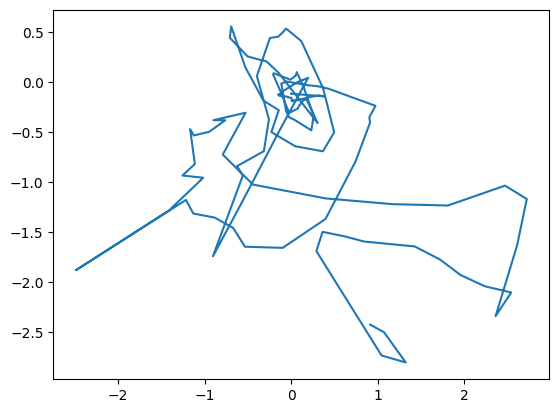

In [79]:
plt.plot(rel_pos[0].cpu()[: , 0] , rel_pos[0].cpu()[: , 1] )

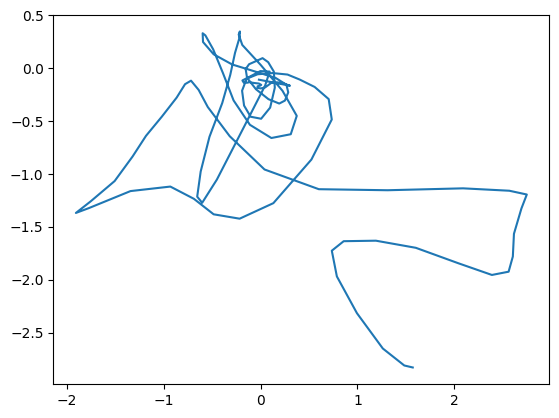

In [80]:
plt.plot(pred_traj[0][: , 0] , pred_traj[0][: , 1] )

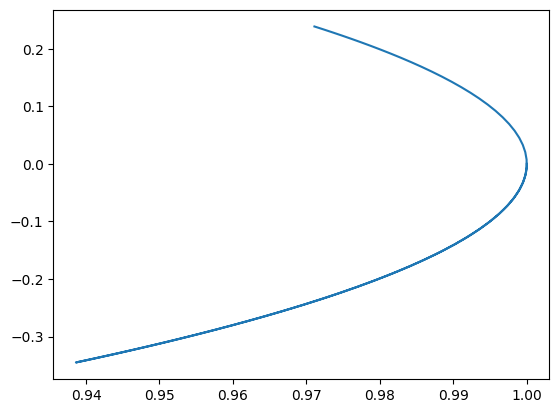

In [77]:
plt.plot(r_rot2[0].cpu()[: , 0] , r_rot2[0].cpu()[: , 1] )

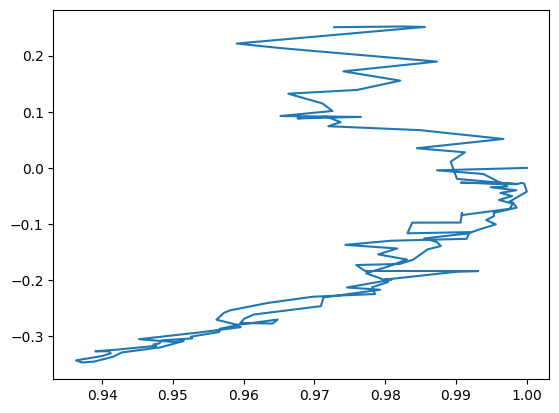

In [78]:
plt.plot(pred_orient[0][: , 0] , pred_orient[0][: , 1] )